In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]

outdir = "/data/Mito_Trace/output/clone_pileups_simulation/samePos/"

ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

pileup_outdir = "MT/cellr_True/numread_200/"
clones_dir = "filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"


#/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/

In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)


fig_utils from mplh
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)

samePos_outdir = join(outdir, curr_out_meta, curr_out_seq) #join(pile_in, "samePos")
#samePos_meta_outdir = join(pile_in, "samePos")

donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


In [4]:
samePos_outdir

'/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10'

In [5]:
barcode_dir = join(samePos_outdir, "data/merged", pileup_outdir , clones_dir, "barcodes/btwnClones_dendro_dt_0.6/")

barcode_dir

'/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6/'

In [6]:
from glob import glob

In [7]:
from os.path import basename

In [8]:
don_means_d = {}
for i in glob(join(barcode_dir, "donor*.mean.csv")):
    don_means_d[basename(i.replace(".mean.csv", "").replace("donor", ""))] = pd.read_csv(i, index_col=0)
don_means_d

{'0':             8953G    11719A    14350G    11150T    12920G     1558G    12833T  \
 lineage                                                                         
 0_0      0.897933  0.877451  0.876577  0.885495  0.896866  0.889853  0.889133   
 0_3      0.886934  0.878430  0.887030  0.886934  0.891999  0.889275  0.884418   
 0_4      0.884624  0.889778  0.883171  0.880519  0.875572  0.885611  0.878738   
 0_1      0.871870  0.877416  0.883618  0.896089  0.884108  0.879717  0.889947   
 0_2      0.885715  0.886161  0.879203  0.877399  0.886678  0.891925  0.891178   
 
             9528G     4832A     5767T  ...     6331A    11719T    12606A  \
 lineage                                ...                                 
 0_0      0.889497  0.888365  0.882894  ...  0.000932  0.000579  0.000383   
 0_3      0.889462  0.882583  0.885501  ...  0.000300  0.000630  0.000466   
 0_4      0.881001  0.882394  0.885607  ...  0.000167  0.000409  0.000091   
 0_1      0.888811  0.885621  0.88

## Load all variables

## make 1-based ref here for output

In [9]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i+1}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([1+np.array(range(len(ref_char))),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
1_G,1,G
2_A,2,A
3_T,3,T
4_C,4,C
5_A,5,A


In [10]:
don_vars_df = pd.read_csv(join(samePos_outdir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(samePos_outdir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(samePos_outdir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(samePos_outdir, "clones_meta.csv"), index_col=0)

clones_meta_cond_df.head()

,clone,condition,donor,ncells
0,d0cl4,0,0,48
1,d0cl4,1,0,73
2,d0cl4,2,0,60
3,d1cl0,0,1,63
4,d1cl0,1,1,61


### Generate cells with donor and clone assignment

In [11]:
donors = all_cells_df["donor"].unique()
conditions = all_cells_df["condition"].unique()
conditions

array([0, 1, 2])

### Generate clone meta with ncells, do for condition and groupby it

In [12]:
# Make clones_meta_cond_df and clones_meta_df
clones_meta_cond_df = all_cells_df.groupby(["clone", "condition", "donor"]).size().to_frame('ncells').reset_index()
clones_meta_cond_df

,clone,condition,donor,ncells
0,d0cl0,0,0,69
1,d0cl0,1,0,58
2,d0cl0,2,0,65
3,d0cl1,0,0,46
4,d0cl1,1,0,65
5,d0cl1,2,0,63
6,d0cl2,0,0,63
7,d0cl2,1,0,44
8,d0cl2,2,0,59
9,d0cl3,0,0,74


In [13]:
clones_meta_df = clones_meta_cond_df.groupby(["clone", "donor"]).sum()["ncells"].to_frame("ncells").reset_index()
clones_meta_df

,clone,donor,ncells
0,d0cl0,0,192
1,d0cl1,0,174
2,d0cl2,0,166
3,d0cl3,0,187
4,d0cl4,0,181
5,d1cl0,1,183
6,d1cl1,1,178
7,d1cl2,1,181
8,d1cl3,1,171
9,d1cl4,1,187


In [14]:
# ## Convert to nt's
# all_nt_pileup = {}
# all_coverage = {}
# for cond in conditions: #curr_out_df in pileups_df_strand.groupby(["nt", "condition"]):
#     for nt in chars:
#         cond_outdir = join(samePos_outdir, "data", f"cond{cond}", pileup_outdir)
#         print(cond_outdir)
#         print(nt,cond)
        
#         all_nt_pileup[(cond, nt)] = pd.read_csv(join(cond_outdir, f"cond{cond}.{nt}.strands.txt"), 
#                                              header=None)
#     all_coverage[cond] = pd.read_csv(join(cond_outdir, f"cond{cond}.coverage.strands.txt"), 
#                                  header=None)
#     #curr_out.to_csv(join(outdir, f"cond_{cond}.{nt}.strands.txt.gz"), compression='gzip')

# all_coverage_df = pd.concat(all_coverage).reset_index(drop=True).pivot(index=1,columns=0, values=2)
# all_coverage_df

## Create variant-by-cell matrix for each variant 

## Calculate AF

# all_nt_df = pd.concat(all_nt_pileup).reset_index().rename({"level_0":"condition","level_1":"nt"}, axis=1).drop("level_2", axis=1)
# all_nt_df["coverage"] = all_nt_df[2] + all_nt_df[4]
# all_nt_df["af"] = all_nt_df.apply(lambda x: x["coverage"]/all_coverage_df.loc[x[1], x[0]]  ,axis=1)
# all_nt_df["Variant"]  = all_nt_df.apply(lambda x: f"{x[0]}>{x['nt']}", axis=1)
# all_nt_df = all_nt_df.pivot(index=1,columns="Variant", values="af")
# all_nt_df = all_nt_df.fillna(0)
# all_nt_df

## Plot all variants (ref and alt)

In [15]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest

## Get just the variants in same position

from collections import Counter

var_pos = [int(x.split(">")[0]) for x in vars_of_interest.index]
vars_of_interest["var_pos"] = var_pos

pos_counts = Counter(var_pos)
same_pos = []
for ind, val  in vars_of_interest.iterrows():
    if pos_counts[val["var_pos"]] > 1:
        same_pos.append(ind)

vars_of_interest["samePos"] = 0
vars_of_interest.loc[same_pos, "samePos"] = 1

vars_of_interest["Variant"] = [x.replace(">", "") for x in vars_of_interest.index]
vars_of_interest = vars_of_interest.set_index("Variant",drop=False)
vars_of_interest = vars_of_interest.astype(str)


samePos_vars = vars_of_interest[vars_of_interest["samePos"]=="1"]
samePos_vars

,donor,clone,var_pos,samePos,Variant
Variant,,,,,
7369T,0,d0cl0,7369,1,7369T
6842A,0,d0cl0,6842,1,6842A
7151T,0,d0cl1,7151,1,7151T
11719C,1,d1cl0,11719,1,11719C
7369A,1,d1cl2,7369,1,7369A
6842G,1,d1cl1,6842,1,6842G
7151A,0,d0cl4,7151,1,7151A
11719A,0,nan,11719,1,11719A
14350G,0,nan,14350,1,14350G


In [16]:
ref_df[ref_df["pos"] == "7150"]

,pos,ref
7150_T,7150,T


In [17]:
ref_df[ref_df["pos"] == "7151"]

,pos,ref
7151_C,7151,C


In [18]:
ref_df[ref_df["pos"] == "7152"]

,pos,ref
7152_A,7152,A


In [19]:
ref_df[ref_df["pos"] == "7368"]

,pos,ref
7368_T,7368,T


In [20]:
ref_df[ref_df["pos"] == "7369"]

,pos,ref
7369_C,7369,C


In [21]:
ref_df[ref_df["pos"] == "7370"]

,pos,ref
7370_C,7370,C


## It appears that none of the variants got into the barcodes!

Number of variants in donor: (5, 43), # of samePos: 6, # in donor 6
Number of variants in donor: (5, 43), # of samePos: 5, # in donor 4


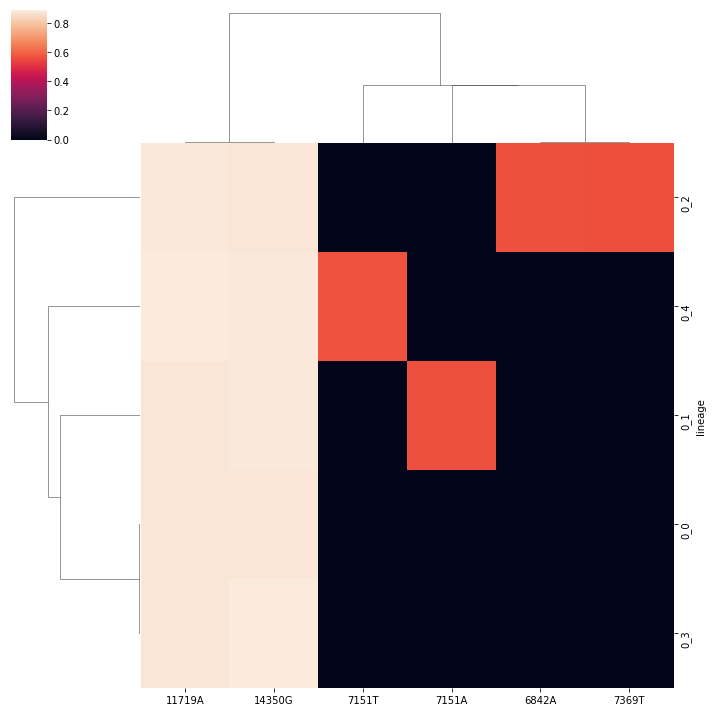

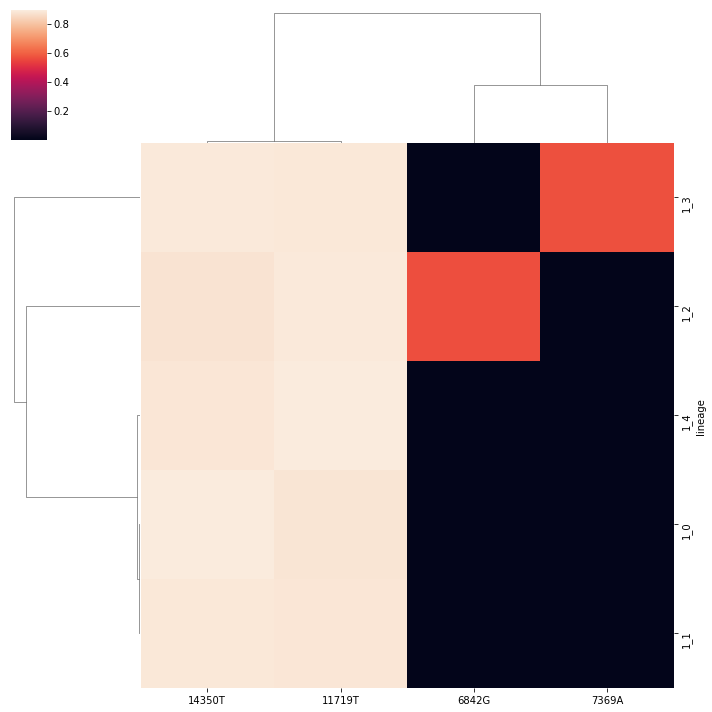

In [22]:
for d in don_means_d:
    curr_v = samePos_vars[samePos_vars["donor"] == d]
    
    var_in_output = sum(x in don_means_d[d].columns.values for x in curr_v.index)
    #var_in_output = don_means_d[d].index.isin(curr_v).sum()
    print(f"Number of variants in donor: {don_means_d[d].shape}, # of samePos: {len(curr_v)}, # in donor {var_in_output}")
    try:
        sns.clustermap(don_means_d[d].loc[:,don_means_d[d].columns.isin(curr_v.index)])
    except ValueError:
        plt.close()
        print("Too few samples")
          

In [31]:
samePos_vars

,donor,clone,var_pos,samePos,Variant
Variant,,,,,
7369T,0,d0cl0,7369,1,7369T
6842A,0,d0cl0,6842,1,6842A
7151T,0,d0cl1,7151,1,7151T
11719C,1,d1cl0,11719,1,11719C
7369A,1,d1cl2,7369,1,7369A
6842G,1,d1cl1,6842,1,6842G
7151A,0,d0cl4,7151,1,7151A
11719A,0,nan,11719,1,11719A
14350G,0,nan,14350,1,14350G


Number of variants in donor: (5, 43), # of samePos: 6, # in donor 6
Number of variants in donor: (5, 43), # of samePos: 5, # in donor 4


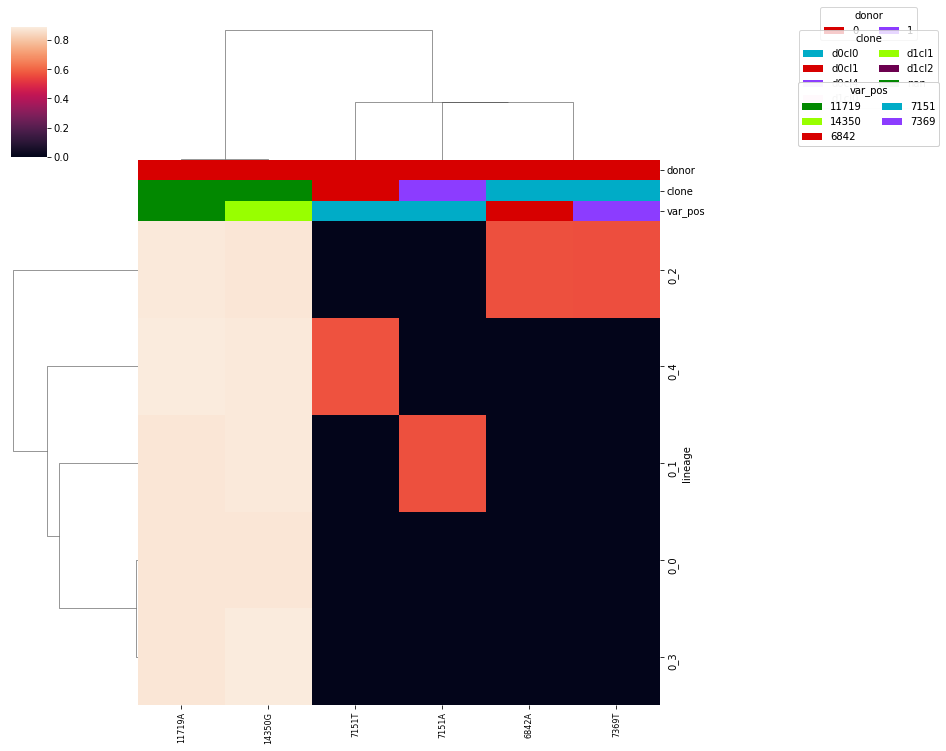

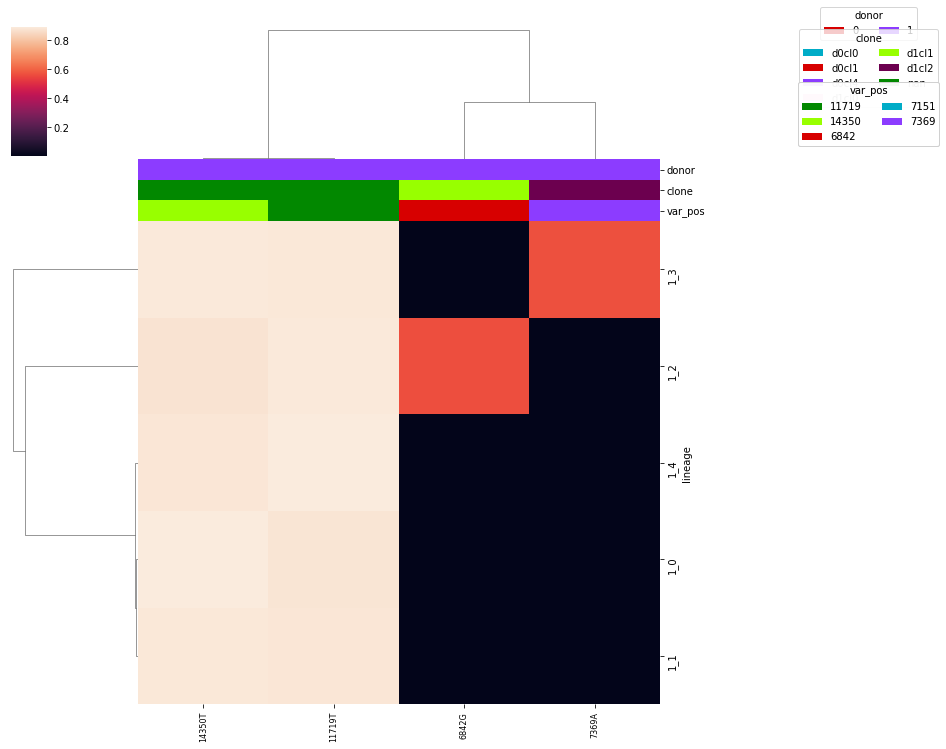

In [35]:
%matplotlib inline
for d in don_means_d:
    curr_v = samePos_vars[samePos_vars["donor"] == d]
    
    var_in_output = sum(x in don_means_d[d].columns.values for x in curr_v.index)
    #var_in_output = don_means_d[d].index.isin(curr_v).sum()
    print(f"Number of variants in donor: {don_means_d[d].shape}, # of samePos: {len(curr_v)}, # in donor {var_in_output}")

    ch.plot_cluster(don_means_d[d].loc[:,don_means_d[d].columns.isin(curr_v.index)],
                    col_meta=samePos_vars.drop(["Variant", "samePos"],axis=1).astype(str),
                    col_clr_schemes="categorical")
    
#plt.savefig(join(curr_outdir, "af.png"))

In [24]:
for d in don_means_d:
    curr_v = samePos_vars[samePos_vars["donor"] == d]
    curr_v_1based = curr_v.copy()
    curr_v_1based["var_pos"] = curr_v_1based["var_pos"].astype(int)+1
    curr_v_1based.index = curr_v_1based.apply(lambda x: f'{str(x["var_pos"])}{x.name[-1]}', axis=1)
    curr_v_1based   
    
    var_in_output = sum(x in don_means_d[d].columns.values for x in curr_v_1based.index)
    #var_in_output = don_means_d[d].index.isin(curr_v).sum()
    print(f"Number of variants in donor: {don_means_d[d].shape}, # of samePos: {len(curr_v_1based)}, # in donor {var_in_output}")
    try:
        sns.clustermap(don_means_d[d].loc[:,don_means_d[d].columns.isin(curr_v_1based.index)])
    except ValueError:
        plt.close()
        print("Too few samples")
          

Number of variants in donor: (5, 43), # of samePos: 6, # in donor 0
Too few samples
Number of variants in donor: (5, 43), # of samePos: 5, # in donor 0


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


Too few samples


In [25]:
for d in don_means_d:
    curr_v = samePos_vars[samePos_vars["donor"] == d]
    curr_v_1based = curr_v.copy()
    curr_v_1based["var_pos"] = curr_v_1based["var_pos"].astype(int)-1
    curr_v_1based.index = curr_v_1based.apply(lambda x: f'{str(x["var_pos"])}{x.name[-1]}', axis=1)
    curr_v_1based   
    
    var_in_output = sum(x in don_means_d[d].columns.values for x in curr_v_1based.index)
    #var_in_output = don_means_d[d].index.isin(curr_v).sum()
    print(f"Number of variants in donor: {don_means_d[d].shape}, # of samePos: {len(curr_v_1based)}, # in donor {var_in_output}")
    try:
        sns.clustermap(don_means_d[d].loc[:,don_means_d[d].columns.isin(curr_v_1based.index)])
    except ValueError:
        plt.close()
        print("Too few samples")
          

Number of variants in donor: (5, 43), # of samePos: 6, # in donor 0
Too few samples
Number of variants in donor: (5, 43), # of samePos: 5, # in donor 0
Too few samples


In [26]:
don_means_d[d]

,12606A,14350T,6208C,14115A,5549A,5781A,8817T,1619A,11719T,6331A,...,4225C,12920G,1972G,5663G,9528G,13461A,2549A,6290A,1417G,6232G
lineage,,,,,,,,,,,,,,,,,,,,,
1_0,0.881833,0.891250,0.884755,0.879836,0.885707,0.881589,0.886167,0.884700,0.877989,0.889256,...,0.000456,0.000456,0.000208,0.000091,0.000091,0.000143,0.000260,0.559727,0.563339,0.565170
1_4,0.877895,0.883605,0.877483,0.886896,0.885114,0.882837,0.884157,0.889490,0.894460,0.887543,...,0.000758,0.000102,0.000306,0.000058,0.000044,0.000219,0.000175,0.000073,0.000204,0.000292
1_2,0.879912,0.876462,0.890646,0.875594,0.878733,0.885951,0.884996,0.877378,0.889710,0.889396,...,0.000330,0.000096,0.000481,0.000316,0.000399,0.000193,0.000179,0.000083,0.000220,0.000220
1_1,0.880779,0.885687,0.892232,0.887033,0.881404,0.883941,0.886571,0.873898,0.882814,0.877956,...,0.000027,0.000068,0.000081,0.000298,0.000502,0.000570,0.000353,0.000190,0.000312,0.000095
1_3,0.899066,0.889669,0.881950,0.876798,0.873699,0.877629,0.873625,0.886009,0.887471,0.883371,...,0.000305,0.000305,0.000111,0.000152,0.000277,0.000139,0.000291,0.000374,0.000152,0.000554


## Using all variants does show up

In [27]:
curr_v

,donor,clone,var_pos,samePos,Variant
Variant,,,,,
11719C,1,d1cl0,11719,1,11719C
7369A,1,d1cl2,7369,1,7369A
6842G,1,d1cl1,6842,1,6842G
11719T,1,nan,11719,1,11719T
14350T,1,nan,14350,1,14350T


In [28]:
vars_of_interest[vars_of_interest["donor"] == "0"]

,donor,clone,var_pos,samePos,Variant
Variant,,,,,
7369T,0,d0cl0,7369,1,7369T
6842A,0,d0cl0,6842,1,6842A
7151T,0,d0cl1,7151,1,7151T
15306G,0,d0cl1,15306,0,15306G
4225C,0,d0cl2,4225,0,4225C
2841C,0,d0cl2,2841,0,2841C
5663G,0,d0cl2,5663,0,5663G
2549A,0,d0cl3,2549,0,2549A
1972G,0,d0cl3,1972,0,1972G



Donor 0
Number of variants in donor: (5, 43), # of samePos: 22
# in donor 22 
Total variants of interest from donor: 22
% sim variants picked up in donor 1.0

Donor 1
Number of variants in donor: (5, 43), # of samePos: 22
# in donor 21 
Total variants of interest from donor: 22
% sim variants picked up in donor 0.9545454545454546


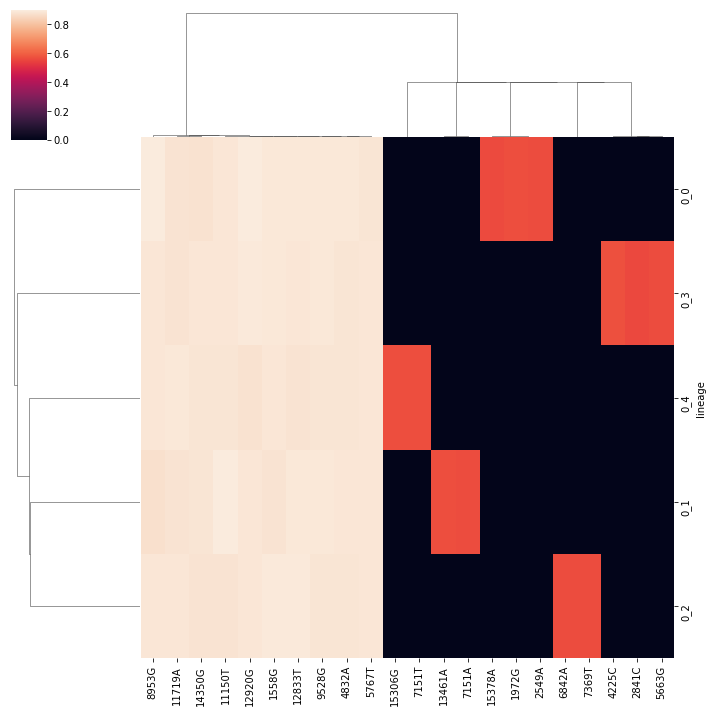

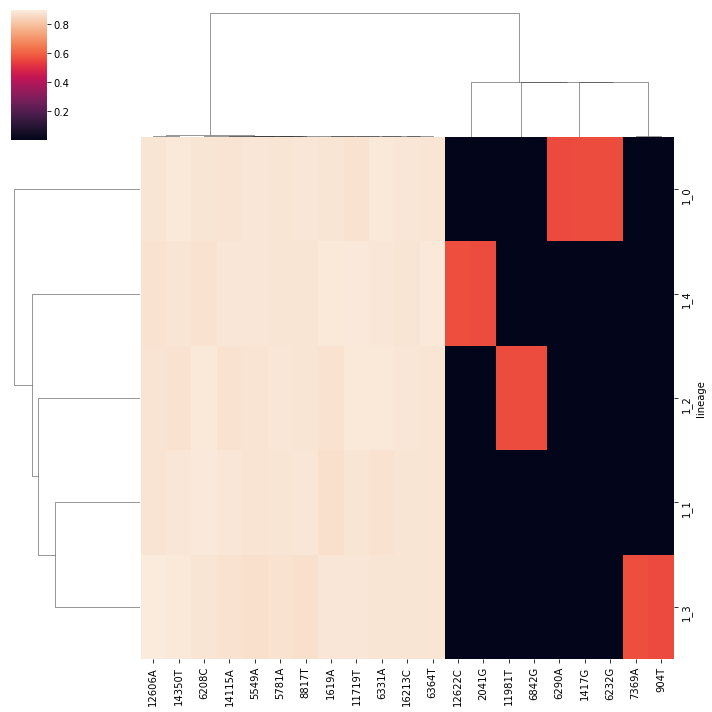

In [29]:
for d in don_means_d:
    print(f"\nDonor {d}")
    curr_v = vars_of_interest[vars_of_interest["donor"] == d]
    
    var_in_output = sum(x in don_means_d[d].columns.values for x in curr_v.index)
    #var_in_output = don_means_d[d].index.isin(curr_v).sum()
    print(f"Number of variants in donor: {don_means_d[d].shape}, # of samePos: {len(curr_v)}")

    print(f"# in donor {var_in_output} \nTotal variants of interest from donor: {len(curr_v)}")
    
    print(f"% sim variants picked up in donor {var_in_output/len(curr_v)}")
    sns.clustermap(don_means_d[d].loc[:,don_means_d[d].columns.isin(curr_v.index)])
    

In [30]:
var_set = set()
curr_len = 0
for d in don_means_d:
    print(don_means_d[d].columns)
    var_set = var_set.union(set(don_means_d[d].columns.values))
    if len(var_set) == curr_len:
        print("same variants!")
    curr_len = len(var_set)
    

Index(['8953G', '11719A', '14350G', '11150T', '12920G', '1558G', '12833T',
       '9528G', '4832A', '5767T', '15306G', '7151T', '13461A', '7151A',
       '15378A', '1972G', '2549A', '6842A', '7369T', '16213C', '1619A', '904T',
       '7369A', '5549A', '5781A', '2041G', '14350T', '6364T', '6290A',
       '14115A', '6208C', '11981T', '12622C', '6331A', '11719T', '12606A',
       '1417G', '8817T', '6232G', '6842G', '4225C', '2841C', '5663G'],
      dtype='object')
Index(['12606A', '14350T', '6208C', '14115A', '5549A', '5781A', '8817T',
       '1619A', '11719T', '6331A', '16213C', '6364T', '12622C', '2041G',
       '11981T', '6842G', '7369A', '904T', '7369T', '11719A', '12833T',
       '4832A', '8953G', '5767T', '1558G', '7151A', '6842A', '7151T', '11150T',
       '2841C', '14350G', '15306G', '15378A', '4225C', '12920G', '1972G',
       '5663G', '9528G', '13461A', '2549A', '6290A', '1417G', '6232G'],
      dtype='object')
same variants!
